Warning message:
"package 'rbcb' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'ggthemes' was built under R version 3.6.3"Warning message:
"package 'Quandl' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



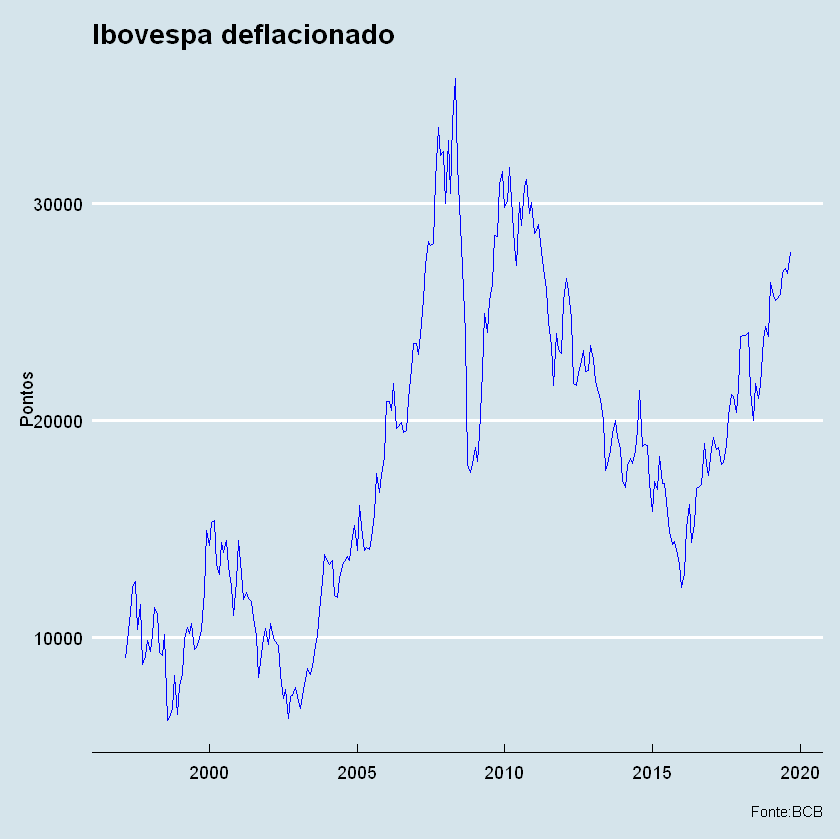

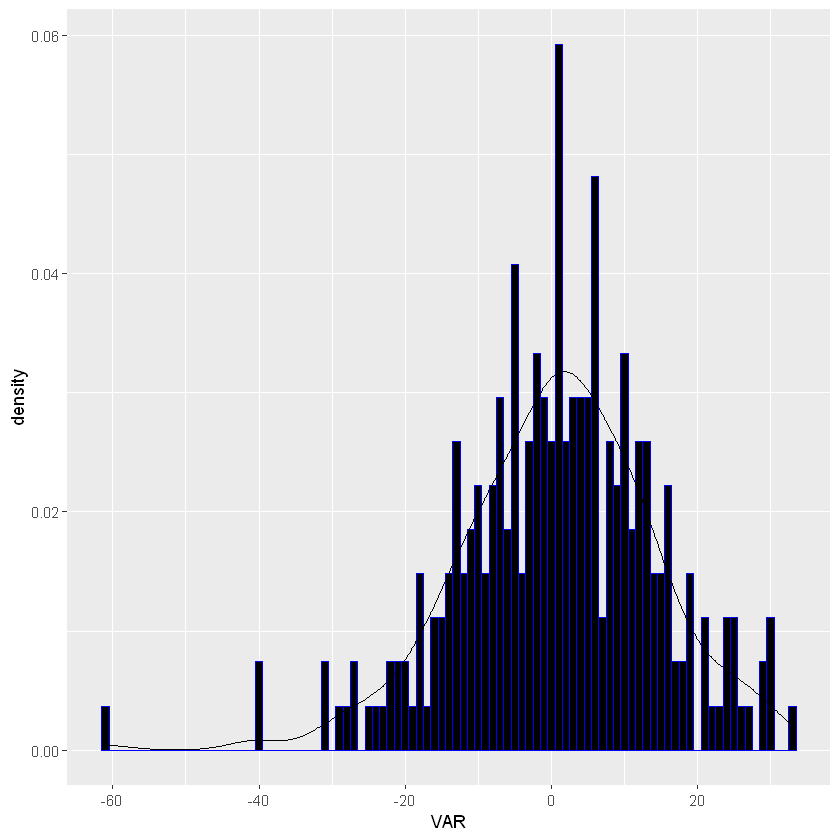

In [1]:
library(rbcb)
library(ggplot2)
library(ggthemes)
library(Quandl)
start <- as.Date("1997-03-01")
inflacao <- get_series(c(IPCA = 433), start_date = start, end_date = "2019-09-30")
ibov <- Quandl(code = "BCB/7", collapse = "monthly")
ibov <- ibov[-which(ibov$Date < start),]
infl <- cumprod((1+(inflacao$IPCA)/100))
ibov_def <- ibov$Value[length(ibov$Value):1]/infl
datas <- seq(start, as.Date("2019-09-30"), "1 month")
ibov_def <- data.frame(Datas = datas ,Valor = ibov_def)
ggplot(ibov_def, aes(x = Datas))+
  geom_line(aes(y = Valor), colour = "blue")+
  labs(x = "", y = "Pontos", title = "Ibovespa deflacionado", caption = "Fonte:BCB")+
  theme_economist()
var <- (diff(ibov_def$Valor,1)/ibov_def$Valor[2:length(ibov_def)])*100
datas2 <- seq(as.Date("1997-04-01"), as.Date("2019-09-30"), "1 month")
var <- data.frame(Data = datas2, VAR = var)
ggplot(var, aes(VAR, after_stat(density)))+
  geom_histogram(fill = "black", colour = "blue", binwidth = 1)+
  geom_density()
